<a href="https://colab.research.google.com/github/LizaAmatya/FakeNewsDetection/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip install -r https://raw.githubusercontent.com/LizaAmatya/FakeNewsDetection/main/requirements.txt

In [ ]:
!pip install matplotlib

In [2]:
# @title
import os
import pandas as pd
import tensorflow as tf
# import tensorflow_text
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
# os.environ["TF_AUTOTUNE"] = "1"
# tf.keras.backend.set_floatx('float16')
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2", "/gpu:3"])

In [4]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.run_functions_eagerly(True)
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# print("All devices: ", tf.config.list_logical_devices())

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [7]:
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = "/content/sample_data"

In [8]:
# # Enable autotuning
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

In [9]:
train_path = os.path.join(BASE_DIR, 'dataset/train.tsv')
test_path = os.path.join(BASE_DIR, 'dataset/test.tsv')
validation_path = os.path.join(BASE_DIR, 'dataset/validation.tsv')

In [10]:
column_labels = ['row', 'json_ids', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'lies_counts', 'context', 'justification']

In [11]:
# Data Frames
train = pd.read_csv(train_path, sep="\t", header=None, names=column_labels)
test = pd.read_csv(test_path, sep="\t", header=None, names=column_labels)
valid = pd.read_csv(validation_path, sep="\t", header=None, names=column_labels)

In [12]:
# Fill nan (empty boxes) with 0
train = train.fillna('None')
test = test.fillna('None')
val = valid.fillna('None')
# print(train['label'])
# print(val['label'])

In [13]:
labels = train['label']
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
label_mapping.update({'pants-fire':5})

num_of_classes=len(label_mapping)
train = train[:100]
val = val[:50]
# print(num_of_classes)

In [14]:
train['label_encoded'] = train['label'].map(label_mapping)
# print(train['label_encoded'])

In [15]:
val['label_encoded'] = val['label'].map(label_mapping)
# print(val['label_encoded'])

In [16]:
# train_one_hot_labels = to_categorical(train['label_encoded'], num_classes=num_of_classes)
# val_one_hot_labels = to_categorical(val['label_encoded'], num_classes=num_of_classes)

In [17]:
# model_name = 'experts_wiki_books'
# model_name = 'bert-base-uncased'
model_name = 'distilbert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name, max_length=128)
tokenizer = DistilBertTokenizer.from_pretrained(model_name, max_length=128)
# vocab_size = 10000
# embedding_dim = 32

In [18]:
# Create a custom embedding layer
# custom_embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)

In [19]:
# Only using statement data at first
# Tokenize the statement data
train_encoded_statement_data = tokenizer(
    train['statement'].to_list(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# print(train_encoded_statement_data)

train_labels = train['label'].tolist()

In [20]:
val_encoded_statement_data = tokenizer(
    val['statement'].tolist(),
    padding=True,
    truncation=True,
    return_tensors='tf'
)

val_labels = val['label'].tolist()

In [21]:
# Create TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encoded_statement_data['input_ids'],
        'attention_mask': train_encoded_statement_data['attention_mask']
    },
    train['label_encoded'] ))  # using one-hot encoded labels when CategoricalCrossEntropy used,
                            # and when using SparseCrossEntropy use train['label_encoded'] which is int rep for labels : 0, 1, 2 ..5

In [22]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encoded_statement_data['input_ids'],
        'attention_mask': val_encoded_statement_data['attention_mask']
    },
    val['label_encoded'] ))  # using one-hot encoded labels when CategoricalCrossEntropy used,
                            # and when using SparseCrossEntropy use train['label_encoded'] which is int rep for labels : 0, 1, 2 ..5

In [23]:
# Limiting the dataset
# limit = 100
# limited_train_dataset = train_dataset.take(limit)

In [24]:
# model = TFBertForSequenceClassification.from_pretrained(model_name)

In [25]:
def create_model():
  model_name = 'distilbert-base-uncased'
  model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
  input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

  bert_output = model([input_ids, attention_mask])
  cls_token = bert_output.logits

  # Adding a dropout layer
  dropout_rate = 0.5  # Adjust the dropout rate as needed
  dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate, name='dropout')(cls_token)

  # Adding a dense layer for the output
  dense_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='dense_output')
  dense_output = dense_layer(dropout_layer)
  # dense_output_expanded = tf.keras.layers.Reshape((1, 6))(dense_output)

  output = tf.keras.layers.Dense(num_of_classes, activation='softmax')(dense_output)

  custom_model = tf.keras.Model(inputs=model.input, outputs=output)
  custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),        #BinaryCrossEntropy for binary classification; for now lets only classify acc to data: 6 classes
            metrics=tf.keras.metrics.SparseCategoricalAccuracy())  # or use ['accuracy']

  return custom_model

In [26]:
num_epochs = 10
batch_size = 32

In [27]:
# custom_embeddings = custom_embedding_layer(input_ids)
# combined_embeddings = tf.keras.layers.Concatenate(axis=-1)([dense_output_expanded, custom_embeddings])


In [28]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    custom_model = create_model()
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#   custom_model = create_model()

custom_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6695501   ['input_ids[0][0]',           
 e_classification (TFDistil  (loss=None, logits=(None,    0          'attention_mask[0][0]']      
 BertForSequenceClassificat  2),                                                              

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(BASE_DIR, 'model_checkpoint'),  # Specify the path to save the checkpoint
    save_best_only=True,  # Save only the best model based on the validation loss
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # Mode can be 'min' or 'max' depending on the monitored metric
    verbose=1  # Show progress while saving
)

In [30]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

train_steps_per_epoch = len(train_dataset)
tqdm_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: tqdm(total=train_steps_per_epoch, position=0, desc="Epoch", unit="batch"),
    on_epoch_end=lambda epoch, logs: tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {logs["loss"]}, Accuracy: {logs["sparse_categorical_accuracy"]}, Val Loss: {logs["val_loss"]}, Val Accuracy: {logs["val_sparse_categorical_accuracy"]}'),
    on_batch_end=lambda batch, logs: tqdm.update(1)
)

class ProgressBarCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs += 1
        self.pbar.update(1)
        self.pbar.set_postfix(logs, refresh=True)

    def on_train_begin(self, logs=None):
        self.epochs = 0
        self.pbar = tqdm(total=self.params['epochs'], unit='epoch', position=0)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [31]:
print('Start training')
progress_bar_callback = ProgressBarCallback()
history = custom_model.fit(
    train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
    verbose=2,
    callbacks=[checkpoint_callback, progress_bar_callback]
)

Start training


  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.77315, saving model to /content/sample_data/model_checkpoint


 10%|█         | 1/10 [01:00<09:04, 60.54s/epoch, loss=1.8, sparse_categorical_accuracy=0.17, val_loss=1.77, val_sparse_categorical_accuracy=0.24]

4/4 - 60s - loss: 1.7999 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7732 - val_sparse_categorical_accuracy: 0.2400 - 60s/epoch - 15s/step
Epoch 2/10

Epoch 2: val_loss did not improve from 1.77315


 20%|██        | 2/10 [01:01<03:24, 25.51s/epoch, loss=1.79, sparse_categorical_accuracy=0.17, val_loss=1.78, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.7941 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7810 - val_sparse_categorical_accuracy: 0.2400 - 923ms/epoch - 231ms/step
Epoch 3/10

Epoch 3: val_loss did not improve from 1.77315


 30%|███       | 3/10 [01:02<01:39, 14.28s/epoch, loss=1.79, sparse_categorical_accuracy=0.17, val_loss=1.78, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.7905 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7842 - val_sparse_categorical_accuracy: 0.2400 - 846ms/epoch - 212ms/step
Epoch 4/10

Epoch 4: val_loss did not improve from 1.77315


 40%|████      | 4/10 [01:03<00:54,  9.00s/epoch, loss=1.78, sparse_categorical_accuracy=0.15, val_loss=1.79, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.7845 - sparse_categorical_accuracy: 0.1500 - val_loss: 1.7868 - val_sparse_categorical_accuracy: 0.2400 - 849ms/epoch - 212ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 1.77315


 50%|█████     | 5/10 [01:04<00:30,  6.09s/epoch, loss=1.79, sparse_categorical_accuracy=0.17, val_loss=1.79, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.7936 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7907 - val_sparse_categorical_accuracy: 0.2400 - 864ms/epoch - 216ms/step
Epoch 6/10

Epoch 6: val_loss did not improve from 1.77315


 60%|██████    | 6/10 [01:05<00:17,  4.34s/epoch, loss=1.81, sparse_categorical_accuracy=0.18, val_loss=1.79, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.8123 - sparse_categorical_accuracy: 0.1800 - val_loss: 1.7920 - val_sparse_categorical_accuracy: 0.2400 - 872ms/epoch - 218ms/step
Epoch 7/10

Epoch 7: val_loss did not improve from 1.77315


 70%|███████   | 7/10 [01:06<00:09,  3.24s/epoch, loss=1.82, sparse_categorical_accuracy=0.2, val_loss=1.79, val_sparse_categorical_accuracy=0.24] 

4/4 - 1s - loss: 1.8150 - sparse_categorical_accuracy: 0.2000 - val_loss: 1.7938 - val_sparse_categorical_accuracy: 0.2400 - 901ms/epoch - 225ms/step
Epoch 8/10

Epoch 8: val_loss did not improve from 1.77315


 80%|████████  | 8/10 [01:07<00:05,  2.61s/epoch, loss=1.83, sparse_categorical_accuracy=0.17, val_loss=1.79, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.8282 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7897 - val_sparse_categorical_accuracy: 0.2400 - 1s/epoch - 296ms/step
Epoch 9/10

Epoch 9: val_loss did not improve from 1.77315


 90%|█████████ | 9/10 [01:08<00:02,  2.22s/epoch, loss=1.79, sparse_categorical_accuracy=0.17, val_loss=1.78, val_sparse_categorical_accuracy=0.24]

4/4 - 1s - loss: 1.7939 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7772 - val_sparse_categorical_accuracy: 0.2400 - 1s/epoch - 317ms/step
Epoch 10/10

Epoch 10: val_loss did not improve from 1.77315


100%|██████████| 10/10 [01:11<00:00,  2.22s/epoch, loss=1.8, sparse_categorical_accuracy=0.17, val_loss=1.78, val_sparse_categorical_accuracy=0.24] 

4/4 - 1s - loss: 1.8035 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7781 - val_sparse_categorical_accuracy: 0.2400 - 936ms/epoch - 234ms/step


100%|██████████| 10/10 [01:11<00:00,  7.11s/epoch, loss=1.8, sparse_categorical_accuracy=0.17, val_loss=1.78, val_sparse_categorical_accuracy=0.24]


In [32]:
# Save the trained model if needed
custom_model.save(os.path.join(BASE_DIR, 'trained_model'))

In [33]:
from keras.utils import Progbar

# Tokenize and preprocess the test data
test_encoded_statement_data = tokenizer(
    test['statement'].tolist(),
    padding=True,
    truncation=True,
    return_tensors='tf'
)
test['label_encoded'] = train['label'].map(label_mapping)

# Create TensorFlow dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encoded_statement_data['input_ids'],
        'attention_mask': test_encoded_statement_data['attention_mask']
    },
    test['label_encoded']
))
# limited_test_dataset = test_dataset.take(limit)
test_steps = len(test_dataset)
progbar = Progbar(test_steps)

# Evaluate the model on the test dataset
with strategy.scope():
  results = custom_model.evaluate(test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Display the results and update the progress bar
for metric_name, result in zip(custom_model.metrics_names, results):
    print(f'{metric_name}: {result}')

    # Update progress bar
    progbar.update(1)
# Print the evaluation results (including accuracy)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



40/40 [==============================] - 16s 349ms/step - loss: nan - sparse_categorical_accuracy: 0.0134
loss: nan
   1/1268 [..............................] - ETA: 7:50:27sparse_categorical_accuracy: 0.013406939804553986
Test Loss: nan
Test Accuracy: 0.013406939804553986


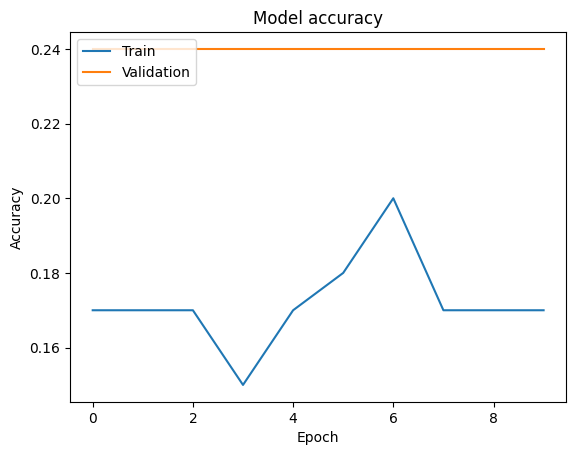

In [36]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()